# <center>  TWEETS DISASTER DETECTION </center>

## This task consists of building classification models classifying tweets indicatinga natural disaster   

#### import needed packages

In [392]:


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.stem import PorterStemmer  
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.sequence import pad_sequences

from xgboost import XGBClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [393]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ydg88\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ydg88\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ydg88\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ydg88\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [394]:
train_tweet=pd.read_csv(r'train.csv')  # load train dataset

In [395]:
train_tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [396]:
train_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### the above info and the first 5 rows of the dataframe provide us with the following information:
* null values in 'keyword' and 'location' columns 
* special characters
* occasional capital letters
* 1/3 of null values in the'location' column
* id column can be safely dropped as it gives no information

In [397]:
target_list=train_tweet.target.tolist()  # save target variable into a list
train_tweet=train_tweet.drop(['id'], axis=1) # drop the id column
train_tweet=train_tweet.drop(['target'], axis=1) # drop the target column, it will be added later

In [398]:
train_tweet # dataframe without 'id' and 'target' columns

,keyword,location,text
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...
1,NaN,NaN,Forest fire near La Ronge Sask. Canada
2,NaN,NaN,All residents asked to 'shelter in place' are ...
3,NaN,NaN,"13,000 people receive #wildfires evacuation or..."
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...
...,...,...,...
7608,NaN,NaN,Two giant cranes holding a bridge collapse int...
7609,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...
7610,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611,NaN,NaN,Police investigating after an e-bike collided ...


### in order to eliminate all special characters and obtain a clean text, all null values need to be converted to string as type-float values will generate errors

In [399]:
train_tweet['keyword'] = train_tweet['keyword'].fillna('key') # replace null values in 'keyword' with 'key'
train_tweet['location'] = train_tweet['location'].fillna('loc') # replace null values in 'keyword' with 'loc'

### Dataframe cleaning 
* convert letters to lowercase 
* remove all special characters

In [400]:
train_tweet=train_tweet.apply(lambda x: x.astype(str).str.lower())
train_tweet=train_tweet.replace('\[.*?\]', ' ', regex=True)
train_tweet= train_tweet.replace('%', ' ', regex= True)
train_tweet= train_tweet.replace('\w*\d\w*', ' ', regex= True)
train_tweet= train_tweet.replace('@', ' ', regex= True)
train_tweet= train_tweet.replace('\\?', ' ', regex= True)
train_tweet= train_tweet.replace('#', ' ', regex= True)
train_tweet= train_tweet.replace('\\\http\S+', ' ', regex= True)
train_tweet = train_tweet.replace('\x89\S+', ' ', regex= True) 
train_tweet = train_tweet.replace('rea\x89û\S+', ' ', regex= True) 

train_tweet= train_tweet.replace('[-()\"#/@;:<>{}`+=~|.!?,]', ' ', regex= True)
train_tweet= train_tweet.replace('[‘’“”…]', ' ', regex= True)
train_tweet= train_tweet.replace('åê', ' ', regex= True)
train_tweet= train_tweet.replace('http\S+', ' ', regex= True)
train_tweet= train_tweet.replace('\$', 's', regex= True)
train_tweet= train_tweet.replace("[\"\',]", '', regex= True)
train_tweet= train_tweet.replace('http', '', regex= True)
train_tweet= train_tweet.replace(' u ', ' you ', regex= True)


train_tweet = train_tweet.replace(r'\s+', ' ', regex=True)
train_tweet.keyword = train_tweet.keyword.replace(r'\s+', '', regex=True)

train_tweet['target']=target_list # include target column

In [401]:
train_tweet

,keyword,location,text,target
0,key,loc,our deeds are the reason of this earthquake ma...,1
1,key,loc,forest fire near la ronge sask canada,1
2,key,loc,all residents asked to shelter in place are be...,1
3,key,loc,people receive wildfires evacuation orders in...,1
4,key,loc,just got sent this photo from ruby alaska as s...,1
...,...,...,...,...
7608,key,loc,two giant cranes holding a bridge collapse int...,1
7609,key,loc,aria_ahrary thetawniest the out of control wi...,1
7610,key,loc,s of volcano hawaii t co,1
7611,key,loc,police investigating after an e bike collided ...,1


In [402]:
dict_keyword=dict(train_tweet.keyword.value_counts()) # word frequency dictionary
print(dict_keyword)

{'body': 107, 'emergency': 105, 'suicide': 99, 'burning': 71, 'fire': 71, 'nuclear': 70, 'buildings': 68, 'mass': 65, 'key': 61, 'forest': 51, 'fatalities': 45, 'armageddon': 42, 'deluge': 42, 'damage': 41, 'harm': 41, 'sinking': 41, 'twister': 40, 'evacuate': 40, 'siren': 40, 'windstorm': 40, 'fear': 40, 'outbreak': 40, 'collided': 40, 'weapons': 39, 'sunk': 39, 'sinkhole': 39, 'famine': 39, 'weapon': 39, 'flames': 39, 'whirlwind': 39, 'earthquake': 39, 'derailment': 39, 'hellfire': 39, 'wreckage': 39, 'collision': 39, 'explosion': 39, 'wrecked': 39, 'hurricane': 38, 'upheaval': 38, 'derailed': 38, 'deaths': 38, 'bombed': 38, 'thunder': 38, 'blaze': 38, 'typhoon': 38, 'fatal': 38, 'ambulance': 38, 'drowned': 38, 'explode': 38, 'oil': 38, 'flooding': 38, 'injury': 38, 'sandstorm': 37, 'panic': 37, 'police': 37, 'quarantined': 37, 'hostages': 37, 'destroy': 37, 'bioterror': 37, 'mudslide': 37, 'blizzard': 37, 'pandemonium': 37, 'ruin': 37, 'crush': 37, 'debris': 37, 'wreck': 37, 'wounde

In [403]:
train_tweet

,keyword,location,text,target
0,key,loc,our deeds are the reason of this earthquake ma...,1
1,key,loc,forest fire near la ronge sask canada,1
2,key,loc,all residents asked to shelter in place are be...,1
3,key,loc,people receive wildfires evacuation orders in...,1
4,key,loc,just got sent this photo from ruby alaska as s...,1
...,...,...,...,...
7608,key,loc,two giant cranes holding a bridge collapse int...,1
7609,key,loc,aria_ahrary thetawniest the out of control wi...,1
7610,key,loc,s of volcano hawaii t co,1
7611,key,loc,police investigating after an e bike collided ...,1


In [404]:
dict_loc=dict(train_tweet.location.value_counts()) # word frequency dictionary
print([str(round((i/train_tweet.shape[0])*100,2))+' %' for i in dict_loc.values()])

['33.27 %', '1.44 %', '1.37 %', '0.99 %', '0.66 %', '0.64 %', '0.43 %', '0.41 %', '0.41 %', '0.39 %', '0.37 %', '0.37 %', '0.33 %', '0.32 %', '0.28 %', '0.26 %', '0.25 %', '0.25 %', '0.24 %', '0.24 %', '0.24 %', '0.22 %', '0.2 %', '0.2 %', '0.18 %', '0.18 %', '0.18 %', '0.18 %', '0.17 %', '0.17 %', '0.17 %', '0.17 %', '0.16 %', '0.16 %', '0.16 %', '0.16 %', '0.16 %', '0.16 %', '0.14 %', '0.14 %', '0.13 %', '0.13 %', '0.13 %', '0.13 %', '0.13 %', '0.13 %', '0.13 %', '0.13 %', '0.12 %', '0.12 %', '0.12 %', '0.12 %', '0.12 %', '0.12 %', '0.11 %', '0.11 %', '0.11 %', '0.11 %', '0.11 %', '0.09 %', '0.09 %', '0.09 %', '0.09 %', '0.09 %', '0.09 %', '0.09 %', '0.09 %', '0.09 %', '0.09 %', '0.09 %', '0.09 %', '0.09 %', '0.08 %', '0.08 %', '0.08 %', '0.08 %', '0.08 %', '0.08 %', '0.08 %', '0.08 %', '0.08 %', '0.08 %', '0.08 %', '0.08 %', '0.08 %', '0.08 %', '0.08 %', '0.08 %', '0.08 %', '0.08 %', '0.08 %', '0.08 %', '0.07 %', '0.07 %', '0.07 %', '0.07 %', '0.07 %', '0.07 %', '0.07 %', '0.07 %', 

'there are 7613 rows in the dataframe and 33.3% are NaN values (coverted to  locs). 
second most frequent value (usas) makes up for less than 1.5% of the entire location columns, therefore
unless we can witness a strong correlation between the NaN values and the target variable, this column can be 
safely dropped'

In [405]:
'the id column can be safely dropped, since it gives us no insight'
'the keyword column will be dropped as well since despite being relevant, its presence does not represent a real life scenario'
'as in several real world cases this variable is not given'
'before deciding what should be done with the location, the content of this variable should be carefully observed'

'before deciding what should be done with the location, the content of this variable should be carefully observed'

The above graph shows that the target variable is almost evenly distributed with respect to the location column and combined with the scarce presence of the remaining categories, this column can be safely dropped 

In [406]:
train_tweet=train_tweet.drop('location', axis=1) # drop location column
train_tweet

,keyword,text,target
0,key,our deeds are the reason of this earthquake ma...,1
1,key,forest fire near la ronge sask canada,1
2,key,all residents asked to shelter in place are be...,1
3,key,people receive wildfires evacuation orders in...,1
4,key,just got sent this photo from ruby alaska as s...,1
...,...,...,...
7608,key,two giant cranes holding a bridge collapse int...,1
7609,key,aria_ahrary thetawniest the out of control wi...,1
7610,key,s of volcano hawaii t co,1
7611,key,police investigating after an e bike collided ...,1


'keyword' column investigation

In [407]:
keyword_frequency_dictionary=dict(train_tweet.keyword.value_counts())
keyword_frequency_dictionary_keys=(list(keyword_frequency_dictionary.keys()))
keyword_frequency_percentage=([(str(round((i/train_tweet.shape[0]*100),2))+' %') for i in keyword_frequency_dictionary.values()])
keyword_frequency_percentage_dict=dict(zip(keyword_frequency_dictionary_keys, keyword_frequency_percentage))
print(keyword_frequency_percentage_dict) # percentage of unique keyword values in dataframe

{'body': '1.41 %', 'emergency': '1.38 %', 'suicide': '1.3 %', 'burning': '0.93 %', 'fire': '0.93 %', 'nuclear': '0.92 %', 'buildings': '0.89 %', 'mass': '0.85 %', 'key': '0.8 %', 'forest': '0.67 %', 'fatalities': '0.59 %', 'armageddon': '0.55 %', 'deluge': '0.55 %', 'damage': '0.54 %', 'harm': '0.54 %', 'sinking': '0.54 %', 'twister': '0.53 %', 'evacuate': '0.53 %', 'siren': '0.53 %', 'windstorm': '0.53 %', 'fear': '0.53 %', 'outbreak': '0.53 %', 'collided': '0.53 %', 'weapons': '0.51 %', 'sunk': '0.51 %', 'sinkhole': '0.51 %', 'famine': '0.51 %', 'weapon': '0.51 %', 'flames': '0.51 %', 'whirlwind': '0.51 %', 'earthquake': '0.51 %', 'derailment': '0.51 %', 'hellfire': '0.51 %', 'wreckage': '0.51 %', 'collision': '0.51 %', 'explosion': '0.51 %', 'wrecked': '0.51 %', 'hurricane': '0.5 %', 'upheaval': '0.5 %', 'derailed': '0.5 %', 'deaths': '0.5 %', 'bombed': '0.5 %', 'thunder': '0.5 %', 'blaze': '0.5 %', 'typhoon': '0.5 %', 'fatal': '0.5 %', 'ambulance': '0.5 %', 'drowned': '0.5 %', 'exp

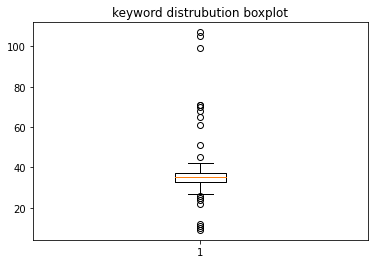

In [408]:
plt.boxplot( keyword_frequency_dictionary.values())
plt.title('keyword distrubution boxplot')
plt.show()

In [409]:
remove_first = dict(list(keyword_frequency_dictionary.items())[1:]) # remove most frequent occurrence in keyword ''

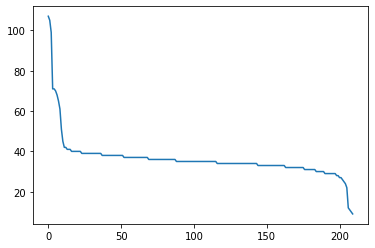

In [410]:
plt.plot(dict(list(keyword_frequency_dictionary.items())).values())

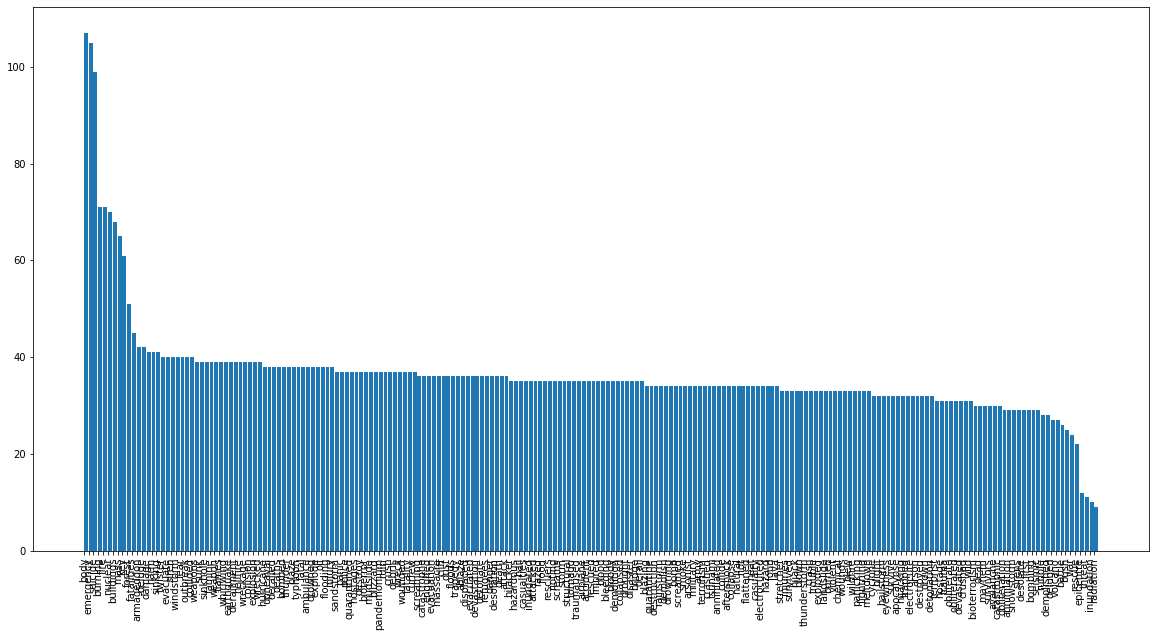

In [411]:
plt.figure(figsize=(20,10))
plt.bar([i for i in range(len(keyword_frequency_dictionary))], list(keyword_frequency_dictionary.values()), align='edge')
plt.xticks(range(len(keyword_frequency_dictionary)), list(keyword_frequency_dictionary.keys()), rotation = 90)
plt.show()

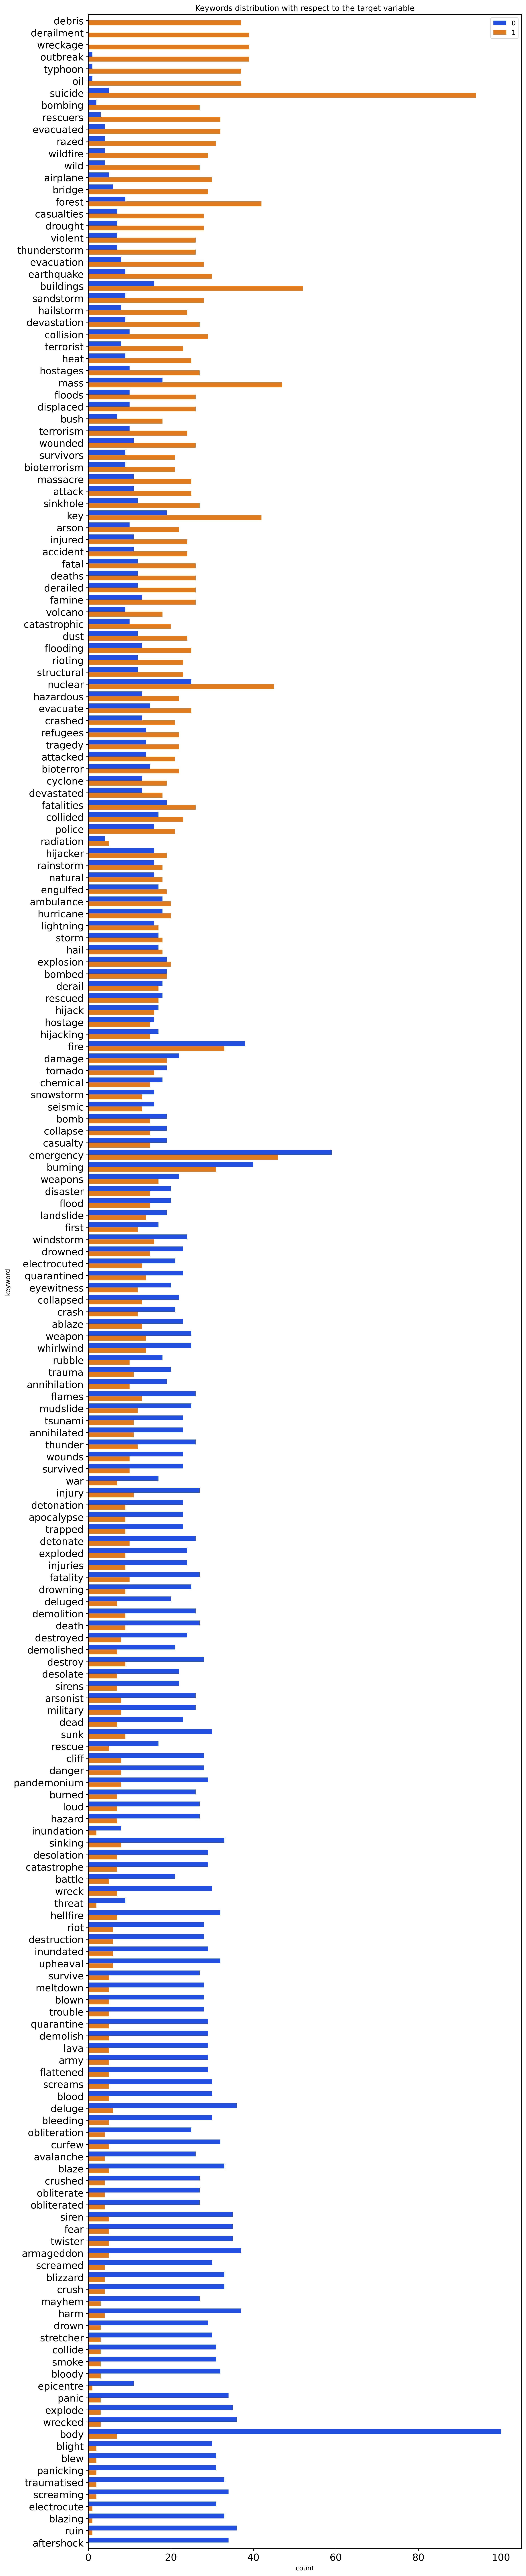

In [412]:



train_tweet['target_mean'] = train_tweet.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(12, 72), dpi=256)

sns.countplot(y=train_tweet.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train_tweet.sort_values(by='target_mean', ascending=False)['target'], palette = "bright")

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.legend(loc=1)
plt.title('Keywords distribution with respect to the target variable')

plt.show()

train_tweet.drop(columns=['target_mean'], inplace=True)


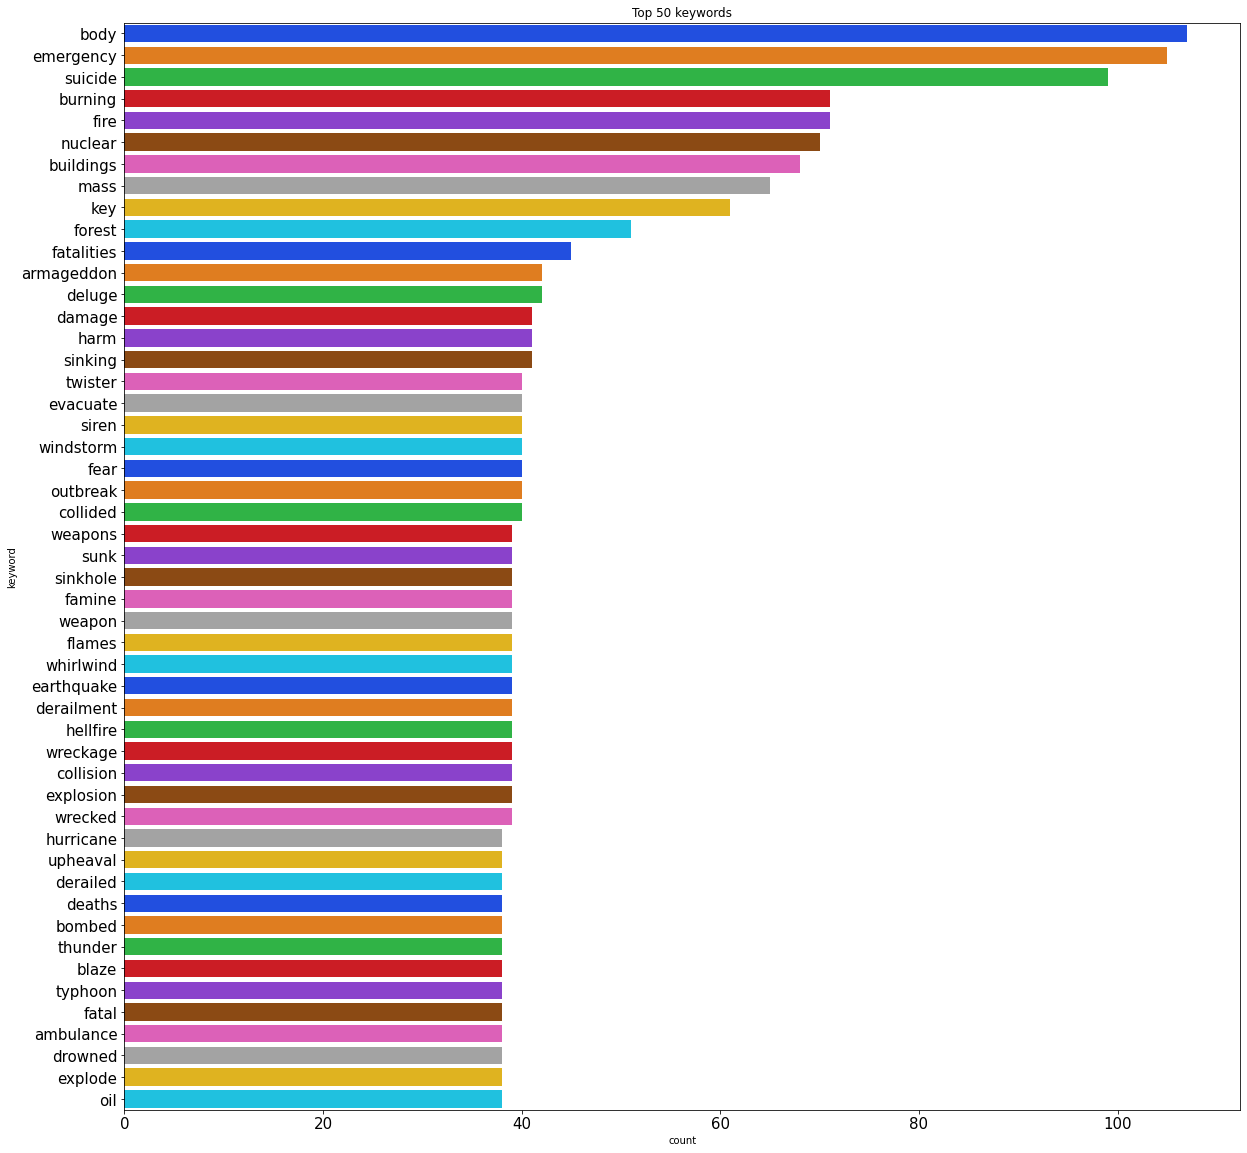

210


In [413]:
plt.figure(figsize=(20,20))

sns.countplot(y = train_tweet.keyword, order = train_tweet.keyword.value_counts().iloc[:50].index, palette='bright')

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.title('Top 50 keywords')
plt.show()

print(len(train_tweet.keyword.value_counts()))


In [414]:

most_frequent_keywords=list(dict(train_tweet.keyword.value_counts()[:50]).keys())

split = list(train_tweet['text'].str.split(' ')) #.explode()

key_loc =  [index for index,value in enumerate(list(train_tweet.keyword)) if 'key' in value]

print(key_loc)

keyword_list=[]
for sentence_index in range(len(split)):
    check =[item for item in split[sentence_index] if item in most_frequent_keywords]
    keyword_list.append(check)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 7583, 7584, 7585, 7586, 7587, 7588, 7589, 7590, 7591, 7592, 7593, 7594, 7595, 7596, 7597, 7598, 7599, 7600, 7601, 7602, 7603, 7604, 7605, 7606, 7607, 7608, 7609, 7610, 7611, 7612]


In [415]:
train_tweet.shape

(7613, 3)

In [416]:
missing_keyword_list=[]
for cell in range(train_tweet.shape[0]):
        if 'key' in list(train_tweet.keyword)[cell] and len(keyword_list[cell]) !=0:
            missing_keyword_list.append(keyword_list[cell])
        elif 'key' in list(train_tweet.keyword)[cell] and len(keyword_list[cell]) ==0:
            missing_keyword_list.append('key')
        else:
            missing_keyword_list.append(list(train_tweet.keyword)[cell])

#print(missing_keyword_list)

#train_tweet['missing_keyword_list'] = train_tweet['missing_keyword_list'].str.get(0)

In [417]:
train_tweet['missing_keywords']=missing_keyword_list
clean_missing_keywords = [', '.join(map(str, l)) for l in train_tweet['missing_keywords']  ]
#train_tweet['missing_keywords']=train_tweet.missing_keywords.apply(lambda x: ''.join(str(x)))
train_tweet['missing_keywords'] = train_tweet['missing_keywords'].astype(str)
train_tweet['missing_keywords'] = train_tweet['missing_keywords'].replace( ['\[',']'],'', regex=True)
train_tweet['missing_keywords'] = train_tweet['missing_keywords'].replace("'", "", regex=True)
#train_tweet.applymap(lambda x: x.replace("'", ' '))
train_tweet

,keyword,text,target,missing_keywords
0,key,our deeds are the reason of this earthquake ma...,1,earthquake
1,key,forest fire near la ronge sask canada,1,"forest, fire"
2,key,all residents asked to shelter in place are be...,1,key
3,key,people receive wildfires evacuation orders in...,1,key
4,key,just got sent this photo from ruby alaska as s...,1,key
...,...,...,...,...
7608,key,two giant cranes holding a bridge collapse int...,1,key
7609,key,aria_ahrary thetawniest the out of control wi...,1,key
7610,key,s of volcano hawaii t co,1,key
7611,key,police investigating after an e bike collided ...,1,collided


In [418]:
train_tweet['text'] = train_tweet['text'].str.replace(re.escape(string.punctuation), ' ')


C:\Users\ydg88\AppData\Local\Temp\ipykernel_8856\902805726.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_tweet['text'] = train_tweet['text'].str.replace(re.escape(string.punctuation), ' ')


In [419]:
train_tweet

,keyword,text,target,missing_keywords
0,key,our deeds are the reason of this earthquake ma...,1,earthquake
1,key,forest fire near la ronge sask canada,1,"forest, fire"
2,key,all residents asked to shelter in place are be...,1,key
3,key,people receive wildfires evacuation orders in...,1,key
4,key,just got sent this photo from ruby alaska as s...,1,key
...,...,...,...,...
7608,key,two giant cranes holding a bridge collapse int...,1,key
7609,key,aria_ahrary thetawniest the out of control wi...,1,key
7610,key,s of volcano hawaii t co,1,key
7611,key,police investigating after an e bike collided ...,1,collided


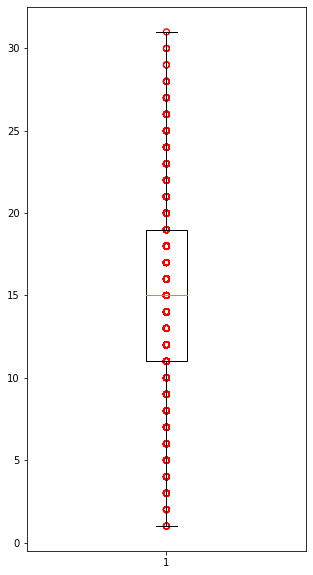

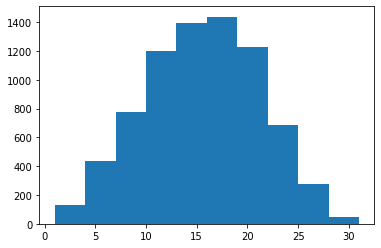

In [420]:
text_sentences_length=[len(i.split()) for i in train_tweet.text]

train_tweet['nr_sentences']=text_sentences_length

ones_list=[]

#ones= [('1')*len(text_sentences_length)]
ones_list.extend(1 for i in range(len(text_sentences_length)))

plt.figure(figsize=(5,10))
plt.boxplot((text_sentences_length))
plt.scatter(ones_list, text_sentences_length, marker='o', facecolors='none', edgecolors='r')
plt.show()
plt.hist(text_sentences_length)
plt.show()

### as we can see, the length of words is normally distributed, we will therefore add another variable to the dataframe containing this aspect


In [421]:
def encode_length(sent_len):
    if sent_len<=10:
        return 'SHORT'
    elif sent_len >= 21:
        return 'LONG'
    else:
        return 'AVG'

train_tweet['sentence_length'] = [encode_length(i) for i in train_tweet.nr_sentences]

In [422]:
train_tweet

,keyword,text,target,missing_keywords,nr_sentences,sentence_length
0,key,our deeds are the reason of this earthquake ma...,1,earthquake,13,AVG
1,key,forest fire near la ronge sask canada,1,"forest, fire",7,SHORT
2,key,all residents asked to shelter in place are be...,1,key,22,LONG
3,key,people receive wildfires evacuation orders in...,1,key,7,SHORT
4,key,just got sent this photo from ruby alaska as s...,1,key,16,AVG
...,...,...,...,...,...,...
7608,key,two giant cranes holding a bridge collapse int...,1,key,12,AVG
7609,key,aria_ahrary thetawniest the out of control wi...,1,key,20,AVG
7610,key,s of volcano hawaii t co,1,key,6,SHORT
7611,key,police investigating after an e bike collided ...,1,collided,22,LONG


In [423]:
stop = stopwords.words('english')
train_tweet['tweet_without_stopwords'] = train_tweet['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
train_tweet

,keyword,text,target,missing_keywords,nr_sentences,sentence_length,tweet_without_stopwords
0,key,our deeds are the reason of this earthquake ma...,1,earthquake,13,AVG,deeds reason earthquake may allah forgive us
1,key,forest fire near la ronge sask canada,1,"forest, fire",7,SHORT,forest fire near la ronge sask canada
2,key,all residents asked to shelter in place are be...,1,key,22,LONG,residents asked shelter place notified officer...
3,key,people receive wildfires evacuation orders in...,1,key,7,SHORT,people receive wildfires evacuation orders cal...
4,key,just got sent this photo from ruby alaska as s...,1,key,16,AVG,got sent photo ruby alaska smoke wildfires pou...
...,...,...,...,...,...,...,...
7608,key,two giant cranes holding a bridge collapse int...,1,key,12,AVG,two giant cranes holding bridge collapse nearb...
7609,key,aria_ahrary thetawniest the out of control wi...,1,key,20,AVG,aria_ahrary thetawniest control wild fires cal...
7610,key,s of volcano hawaii t co,1,key,6,SHORT,volcano hawaii co
7611,key,police investigating after an e bike collided ...,1,collided,22,LONG,police investigating e bike collided car littl...


### Text lemmatization and tokenization

In [424]:
def lemmatize_words(text):
    lemmatizer=WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words]
    return  ' '.join(words)
train_tweet['text_lemmatized'] = train_tweet.tweet_without_stopwords.apply(lemmatize_words)

train_tweet

,keyword,text,target,missing_keywords,nr_sentences,sentence_length,tweet_without_stopwords,text_lemmatized
0,key,our deeds are the reason of this earthquake ma...,1,earthquake,13,AVG,deeds reason earthquake may allah forgive us,deed reason earthquake may allah forgive u
1,key,forest fire near la ronge sask canada,1,"forest, fire",7,SHORT,forest fire near la ronge sask canada,forest fire near la ronge sask canada
2,key,all residents asked to shelter in place are be...,1,key,22,LONG,residents asked shelter place notified officer...,resident asked shelter place notified officer ...
3,key,people receive wildfires evacuation orders in...,1,key,7,SHORT,people receive wildfires evacuation orders cal...,people receive wildfire evacuation order calif...
4,key,just got sent this photo from ruby alaska as s...,1,key,16,AVG,got sent photo ruby alaska smoke wildfires pou...,got sent photo ruby alaska smoke wildfire pour...
...,...,...,...,...,...,...,...,...
7608,key,two giant cranes holding a bridge collapse int...,1,key,12,AVG,two giant cranes holding bridge collapse nearb...,two giant crane holding bridge collapse nearby...
7609,key,aria_ahrary thetawniest the out of control wi...,1,key,20,AVG,aria_ahrary thetawniest control wild fires cal...,aria_ahrary thetawniest control wild fire cali...
7610,key,s of volcano hawaii t co,1,key,6,SHORT,volcano hawaii co,volcano hawaii co
7611,key,police investigating after an e bike collided ...,1,collided,22,LONG,police investigating e bike collided car littl...,police investigating e bike collided car littl...


In [425]:
train_tweet['keyword_text_length']= train_tweet['text_lemmatized']+' '+train_tweet['sentence_length'] + ' ' +  train_tweet['keyword']


In [426]:

longest_sentence = max(train_tweet['nr_sentences'])

# Convert Pandas DataFrame to TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices(train_tweet['keyword_text_length'])
# Define vocabulary size
vocab_size = 10000
# Create a Tokenizer
tokenizer = Tokenizer(num_words=10000,  oov_token='OOV')
# Fit Tokenizer on text data
tokenizer.fit_on_texts(train_tweet['keyword_text_length'])

# Create a vocabulary from Tokenizer
vocab = tokenizer.word_index

# Convert text data to numerical data
sequences = tokenizer.texts_to_sequences(train_tweet['keyword_text_length'])

# Pad sequences to a fixed length
max_len = longest_sentence
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')


print(padded_sequences)


'''tokens = Tokenizer(num_words= longest_sentence, oov_token='OOV')
tokens.fit_on_texts(train_tweet['keyword_text_length'])
sequences = tokens.texts_to_sequences(train_tweet['keyword_text_length'])
word_index = tokens.word_index
print(sequences)
print(word_index)'''

[[3999  518   90 ...    0    0    0]
 [  54    6  305 ...    0    0    0]
 [1553 1434 1725 ...    0    0    0]
 ...
 [ 267 1422    2 ...    0    0    0]
 [  22 1028  482 ...    0    0    0]
 [ 284   35  219 ...    0    0    0]]


"tokens = Tokenizer(num_words= longest_sentence, oov_token='OOV')\ntokens.fit_on_texts(train_tweet['keyword_text_length'])\nsequences = tokens.texts_to_sequences(train_tweet['keyword_text_length'])\nword_index = tokens.word_index\nprint(sequences)\nprint(word_index)"

In [458]:
y = train_tweet.target
X = padded_sequences

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=30, test_size=0.25)

In [459]:
'''model = Sequential()

# Input - Layer
model.add(layers.Dense(500, activation = "relu", input_shape=(31, )))
# Hidden - Layers
#model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
model.add(layers.Dense(150, activation = "relu"))
#model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
model.add(layers.Dense(150, activation = "relu"))
# Output- Layer
model.add(layers.Dense(1, activation = "sigmoid"))
model.summary()'''

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 500)               16000     
                                                                 
 dense_37 (Dense)            (None, 150)               75150     
                                                                 
 dense_38 (Dense)            (None, 150)               22650     
                                                                 
 dense_39 (Dense)            (None, 1)                 151       
                                                                 
Total params: 113,951
Trainable params: 113,951
Non-trainable params: 0
_________________________________________________________________


In [479]:
model = tf.keras.Sequential([
tf.keras.layers.Embedding(10000,16,input_length = 31),
tf.keras.layers.GlobalAveragePooling1D(),
tf.keras.layers.Dense(6, activation = "relu"),
tf.keras.layers.Dense(1, activation = "sigmoid")
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 31, 16)            160000    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_42 (Dense)            (None, 6)                 102       
                                                                 
 dense_43 (Dense)            (None, 1)                 7         
                                                                 
Total params: 160,109
Trainable params: 160,109
Non-trainable params: 0
_________________________________________________________________


In [480]:
model.compile(optimizer = "adam",loss = "binary_crossentropy",metrics = ["accuracy"])
results = model.fit(X_train, y_train, epochs= 200, batch_size = 32, validation_data = (X_test, y_test) )
y_pred = model.predict(X_test)


Epoch 1/200
179/179 [==============================] - 2s 5ms/step - loss: 0.6824 - accuracy: 0.5735 - val_loss: 0.6766 - val_accuracy: 0.5604
Epoch 2/200
179/179 [==============================] - 1s 4ms/step - loss: 0.6522 - accuracy: 0.5864 - val_loss: 0.6222 - val_accuracy: 0.6707
Epoch 3/200
179/179 [==============================] - 1s 4ms/step - loss: 0.5423 - accuracy: 0.7683 - val_loss: 0.5136 - val_accuracy: 0.7789
Epoch 4/200
179/179 [==============================] - 1s 4ms/step - loss: 0.4200 - accuracy: 0.8389 - val_loss: 0.4620 - val_accuracy: 0.7952
Epoch 5/200
179/179 [==============================] - 1s 4ms/step - loss: 0.3470 - accuracy: 0.8653 - val_loss: 0.4494 - val_accuracy: 0.8020
Epoch 6/200
179/179 [==============================] - 1s 4ms/step - loss: 0.3010 - accuracy: 0.8844 - val_loss: 0.4518 - val_accuracy: 0.7962
Epoch 7/200
179/179 [==============================] - 1s 4ms/step - loss: 0.2674 - accuracy: 0.8954 - val_loss: 0.4647 - val_accuracy: 0.7952

Epoch 58/200
179/179 [==============================] - 1s 4ms/step - loss: 0.0351 - accuracy: 0.9846 - val_loss: 1.4897 - val_accuracy: 0.7279
Epoch 59/200
179/179 [==============================] - 1s 4ms/step - loss: 0.0347 - accuracy: 0.9823 - val_loss: 1.5019 - val_accuracy: 0.7279
Epoch 60/200
179/179 [==============================] - 1s 4ms/step - loss: 0.0344 - accuracy: 0.9828 - val_loss: 1.5162 - val_accuracy: 0.7306
Epoch 61/200
179/179 [==============================] - 1s 4ms/step - loss: 0.0340 - accuracy: 0.9837 - val_loss: 1.5358 - val_accuracy: 0.7237
Epoch 62/200
179/179 [==============================] - 1s 4ms/step - loss: 0.0333 - accuracy: 0.9830 - val_loss: 1.5542 - val_accuracy: 0.7227
Epoch 63/200
179/179 [==============================] - 1s 4ms/step - loss: 0.0342 - accuracy: 0.9830 - val_loss: 1.5648 - val_accuracy: 0.7279
Epoch 64/200
179/179 [==============================] - 1s 4ms/step - loss: 0.0336 - accuracy: 0.9832 - val_loss: 1.5826 - val_accuracy:

Epoch 115/200
179/179 [==============================] - 1s 4ms/step - loss: 0.0306 - accuracy: 0.9848 - val_loss: 2.1130 - val_accuracy: 0.7064
Epoch 116/200
179/179 [==============================] - 1s 4ms/step - loss: 0.0296 - accuracy: 0.9830 - val_loss: 2.1089 - val_accuracy: 0.7195
Epoch 117/200
179/179 [==============================] - 1s 4ms/step - loss: 0.0305 - accuracy: 0.9834 - val_loss: 2.1230 - val_accuracy: 0.7069
Epoch 118/200
179/179 [==============================] - 1s 4ms/step - loss: 0.0298 - accuracy: 0.9832 - val_loss: 2.1234 - val_accuracy: 0.7180
Epoch 119/200
179/179 [==============================] - 1s 4ms/step - loss: 0.0298 - accuracy: 0.9834 - val_loss: 2.1279 - val_accuracy: 0.7264
Epoch 120/200
179/179 [==============================] - 1s 4ms/step - loss: 0.0300 - accuracy: 0.9841 - val_loss: 2.1354 - val_accuracy: 0.7174
Epoch 121/200
179/179 [==============================] - 1s 4ms/step - loss: 0.0301 - accuracy: 0.9828 - val_loss: 2.1422 - val_ac

179/179 [==============================] - 1s 4ms/step - loss: 0.0290 - accuracy: 0.9842 - val_loss: 2.3525 - val_accuracy: 0.6980
Epoch 172/200
179/179 [==============================] - 1s 5ms/step - loss: 0.0284 - accuracy: 0.9834 - val_loss: 2.3438 - val_accuracy: 0.7106
Epoch 173/200
179/179 [==============================] - 1s 5ms/step - loss: 0.0278 - accuracy: 0.9853 - val_loss: 2.3852 - val_accuracy: 0.6938
Epoch 174/200
179/179 [==============================] - 1s 4ms/step - loss: 0.0286 - accuracy: 0.9844 - val_loss: 2.3476 - val_accuracy: 0.7143
Epoch 175/200
179/179 [==============================] - 1s 4ms/step - loss: 0.0284 - accuracy: 0.9844 - val_loss: 2.3562 - val_accuracy: 0.7054
Epoch 176/200
179/179 [==============================] - 1s 4ms/step - loss: 0.0281 - accuracy: 0.9846 - val_loss: 2.3629 - val_accuracy: 0.7017
Epoch 177/200
179/179 [==============================] - 1s 4ms/step - loss: 0.0285 - accuracy: 0.9828 - val_loss: 2.3619 - val_accuracy: 0.7085

In [434]:
y_train.shape

(5709,)

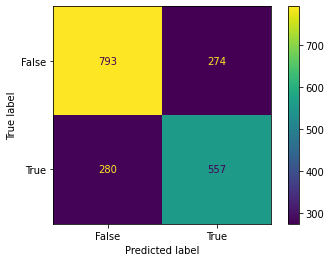

In [483]:
y_pred =(y_pred>0.4)
list(y_pred)


from sklearn import metrics


confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [484]:
print(accuracy_score(y_test, y_pred))

0.7090336134453782


In [485]:
y_pred

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [False],
       [ True]])